# Forecast COVID-19 modeling

## 초기 설정

In [1]:
import sys

sys.path.append('..')  # ROOT 디렉토리 path 추가

In [2]:
# 모듈 자동 리로드

%load_ext autoreload
%autoreload 2

In [3]:
# 필요 라이브러리 임포트
import os
from pathlib import Path
from urllib.request import urlopen, Request
from urllib.parse import urlencode, quote_plus

import torch
import torch.nn as nn
import pytorch_lightning as pl
import pandas as pd
import numpy as np
import xmltodict
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [4]:
ROOT = Path(os.getcwd()).parent

## 데이터 수집

In [5]:
# 공공데이터 포털 API key

with open(ROOT / 'datago_key.txt', 'r') as f:
    service_key = f.read()

In [6]:
service_url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19SidoInfStateJson'

query_params = '?' + urlencode({
    quote_plus('ServiceKey'): service_key,
    quote_plus('pageNo'): '1',
    quote_plus('numOfRows'): '10',
    quote_plus('startCreateDt'): '20200303',
    quote_plus('endCreateDt'): '20220220',
})

req = Request(service_url + query_params)
req.get_method = lambda: 'GET'
response = urlopen(req)

In [7]:
# 정상 응답
if response.status == 200:
    response = xmltodict.parse(response.read())['response']
    # 결과가 정상적으로 반환되었을 때
    if response['header']['resultCode'] == '00':
        # 결과 아이템이 존재할 때
        if response['body']['items']:
            covid_data = pd.DataFrame(response['body']['items']['item'])
            covid_data.sort_values(by=['createDt'], ignore_index=True, inplace=True)
            
covid_data

,createDt,deathCnt,defCnt,gubun,gubunCn,gubunEn,incDec,isolClearCnt,localOccCnt,overFlowCnt,qurRate,seq,stdDay,updateDt
0,2020-03-03 09:00:00.000,0,0,검역,隔離區,Lazaretto,0,0,0,0,0.00,818,2020년 03월 03일 00시,2021-09-16 10:11:33.897
1,2020-03-03 09:00:00.000,28,4812,합계,合计,Total,600,34,599,1,9.28,836,2020년 03월 03일 00시,2021-09-16 10:11:33.897
2,2020-03-03 09:00:00.000,0,98,서울,首尔,Seoul,7,13,7,0,1.01,835,2020년 03월 03일 00시,2021-09-16 10:11:33.897
3,2020-03-03 09:00:00.000,0,87,부산,釜山,Busan,2,0,2,0,2.55,834,2020년 03월 03일 00시,2021-09-16 10:11:33.897
4,2020-03-03 09:00:00.000,20,3604,대구,大邱,Daegu,520,2,520,0,147.92,833,2020년 03월 03일 00시,2021-09-16 10:11:33.897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13675,2022-02-20 08:53:21.989,53,35837,전남,全南,Jeollanam-do,2064,6931,2060,4,1936,15224,2022년 02월 20일 00시,null
13676,2022-02-20 08:53:21.989,273,60572,경북,庆北,Gyeongsangbuk-do,3349,19098,3342,7,2295,15225,2022년 02월 20일 00시,null
13677,2022-02-20 08:53:21.989,132,78329,경남,庆南,Gyeongsangnam-do,5093,40611,5087,6,2345,15226,2022년 02월 20일 00시,null
13678,2022-02-20 08:53:21.989,14,16102,제주,济州,Jeju,1231,10083,1231,0,2387,15227,2022년 02월 20일 00시,null


## 모델링

In [5]:
covid_data = pd.read_csv(ROOT / 'data/20200303_20220220_covid.csv')

In [6]:
INPUT_LEN = 28
OUTPUT_LEN = 15

In [46]:
inc_dec_data = covid_data[covid_data.gubunEn == 'Total'].incDec.astype('int').values

train_data = inc_dec_data[:int(len(inc_dec_data) * 1)]
test_data = inc_dec_data[int(len(inc_dec_data) * 1):]

print(f'Total len: {len(inc_dec_data)}')
print(f'Train len: {len(train_data)}')
print(f'Test len: {len(test_data)}')

Total len: 720
Train len: 720
Test len: 0


In [48]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
# test_scaled = scaler.transform(test_data.reshape(-1, 1))

In [31]:
class CovidDataset(Dataset):
    def __init__(self, X, y, input_len, output_len):
        self.X = torch.Tensor(X).float()
        self.y = torch.Tensor(y).float()
        self.input_len = input_len
        self.output_len = output_len
        
    def __len__(self):
        return self.X.__len__() - self.input_len - self.output_len + 1
    
    def __getitem__(self, index):
        return (self.X[index:index + self.input_len],
                self.y[index + self.input_len:index + self.input_len + self.output_len])

In [49]:
train_loader = DataLoader(CovidDataset(train_scaled, train_scaled.reshape(-1), INPUT_LEN, OUTPUT_LEN),
                          batch_size=64)
# test_loader = DataLoader(CovidDataset(test_scaled, test_scaled.reshape(-1), INPUT_LEN, OUTPUT_LEN),
#                          batch_size=16)

In [33]:
class LSTMRegressor(pl.LightningModule):
    def __init__(self,
                 n_features,
                 hidden_size,
                 input_len,
                 output_len,
                 num_layers,
                 dropout,
                 learning_rate,
                 criterion):
        super(LSTMRegressor, self).__init__()
        
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True)
        
        self.linear = nn.Linear(hidden_size, output_len)
        
        self.__dict__.update(locals())
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:, -1])
        return y_pred
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log_dict({'loss': loss})

In [50]:
hyp = dict(
    n_features=1,
    hidden_size=128,
    input_len=INPUT_LEN,
    output_len=OUTPUT_LEN,
    num_layers=2,
    dropout=0.2,
    learning_rate=1e-3,
    criterion=nn.MSELoss()
)

In [51]:
model = LSTMRegressor(**hyp)

trainer = pl.Trainer(max_epochs=10,
                     log_every_n_steps=2)
trainer.fit(model, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type   | Params
----------------------------------
0 | lstm   | LSTM   | 199 K 
1 | linear | Linear | 1.9 K 
----------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.804     Total estimated model params size (MB)
/Users/kih/miniforge3/envs/dev-py38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s, loss=0.00631, v_num=11] 


In [52]:
trainer.test(model, train_loader)

/Users/kih/miniforge3/envs/dev-py38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 100%|██████████| 11/11 [00:01<00:00,  6.09it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss': 0.0035907153505831957}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 11/11 [00:01<00:00,  6.85it/s]


[{'loss': 0.0035907153505831957}]

In [53]:
model.eval()

truths = []
preds = []

for X, y in train_loader:
    y_hat = model(X)
    
    truths.append(y)
    preds.append(y_hat)
    
truths = torch.cat(truths).detach().numpy()
preds = torch.cat(preds).detach().numpy()

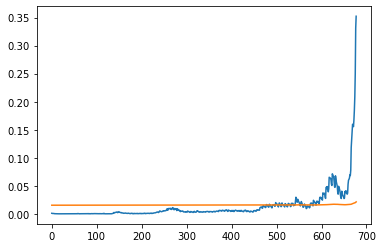

In [55]:
plt.plot(truths[:, 0])
plt.plot(preds[:, 0])
plt.show()